## A demo using two-qubit HeisenbergModel Hamiltonian with GPT-QE (using minGPT code).

In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data.dataloader import DataLoader
from gqe.mingpt.utils import set_seed

set_seed(3407)

In [2]:
from qwrapper.hamiltonian import HeisenbergModel
from qwrapper.operator import PauliObservable
from gqe.mingpt.cost import EnergyCost
from qswift.initializer import ZBasisInitializer
from qswift.compiler import DefaultOperatorPool
from benchmark.molecule import DiatomicMolecularHamiltonian
from gqe.operator_pool.uccsd import UCCSD, generate_molecule
from gqe.common.initializer import HFStateInitializer

molecule = generate_molecule("H", "H", 0.7414, "sto-3g")
nqubit = 4

# prepare Hamiltonian
hamiltonian = DiatomicMolecularHamiltonian(nqubit, molecule)

# prepare operator_pool
uccsd = UCCSD(4, molecule)
paulis = uccsd.paulis
num_operators = len(paulis)
initializer = HFStateInitializer(n_electrons=2)
pool = DefaultOperatorPool(paulis)
cost = EnergyCost(hamiltonian, initializer, pool, [0.025, -0.025, 0.05, -0.05, 0.1, -0.1])


converged SCF energy = -1.11668438708534
Starting to parse FermionOperator using 4 qubits...

Operator t:  -0.09886396933545816 [] +
0.04532220205287399 [X0 Z1 X2] +
0.04532220205287399 [X0 Z1 X2 Z3] +
0.04532220205287399 [Y0 Z1 Y2] +
0.04532220205287399 [Y0 Z1 Y2 Z3] +
0.17119774903432977 [Z0] +
0.17119774903432972 [Z0 Z1] +
0.165867024105892 [Z0 Z1 Z2] +
0.165867024105892 [Z0 Z1 Z2 Z3] +
0.12054482205301804 [Z0 Z2] +
0.12054482205301804 [Z0 Z2 Z3] +
0.1686221915892094 [Z1] +
-0.2227859304041847 [Z1 Z2 Z3] +
0.17434844185575682 [Z1 Z3] +
-0.22278593040418473 [Z2]
Term, coeff:  () -0.09886396933545816
Term, coeff:  ((0, 'Z'),) 0.17119774903432977
Index, p_char:  0 Z
Term, coeff:  ((0, 'Z'), (1, 'Z')) 0.17119774903432972
Index, p_char:  0 Z
Index, p_char:  1 Z
Term, coeff:  ((2, 'Z'),) -0.22278593040418473
Index, p_char:  2 Z
Term, coeff:  ((1, 'Z'), (2, 'Z'), (3, 'Z')) -0.2227859304041847
Index, p_char:  1 Z
Index, p_char:  2 Z
Index, p_char:  3 Z
Term, coeff:  ((1, 'Z'),) 0.1686221915

## FCI energy by diagonalization

In [3]:
from qwrapper.hamiltonian import compute_ground_state

print(compute_ground_state(hamiltonian))

-1.137270174660903


## Setup for GPT

In [4]:
# create a GPT instance
from gqe.mingpt.model import GPT

model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = cost.vocab_size()
model_config.block_size = cost.vocab_size()
model_config.n_gates = 40  # The number of gates for each circuit
model_config.temperature = 20  # Each gate is generated with probability exp(-temperature * logit)
model_config.embd_pdrop = 0.1
model_config.resid_pdrop = 0.1
model_config.attn_pdrop = 0.1
model = GPT(model_config, cost)

number of parameters: 85.16M


(tensor([[49, 51, 49, 60],
         [49, 49,  1, 47]]),
 tensor([[-1.5253, -1.1848, -1.1431, -1.2014],
         [-1.2230, -1.2968, -1.5440, -1.0777]], grad_fn=<PermuteBackward0>))

In [5]:
# create a Trainer object
from gqe.mingpt.trainer import Trainer

train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-7  # the model we're using is so small that we can go a bit faster
train_config.max_iters = 300
train_config.num_workers = 0
train_config.n_samples = 5
trainer = Trainer(train_config, model)

running on device cpu


In [6]:
def batch_end_callback(trainer):
    if trainer.iter_num % 10 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        model.temperature += 0.1


trainer.set_callback('on_batch_end', batch_end_callback)
trainer.run()
torch.save(model.state_dict(), '../saved_models/gptqe_test')

energies: tensor([-0.2201, -0.2905, -0.3878,  0.0409, -0.1841])
mean: tensor(-0.2083)
iter_dt 0.00ms; iter 0: train loss 1.17496
energies: tensor([-0.1091, -0.7228, -0.4549, -0.1809,  0.1037])
mean: tensor(-0.2728)
energies: tensor([-0.6106, -0.2200, -0.3397, -0.2723, -0.2623])
mean: tensor(-0.3410)
energies: tensor([-0.2682, -0.3774, -0.1109, -0.2893, -0.1075])
mean: tensor(-0.2307)
energies: tensor([-0.2257, -0.2886, -0.4470, -0.5533, -0.2513])
mean: tensor(-0.3532)
energies: tensor([-0.2086, -0.1443, -0.3506, -0.6025, -0.2904])
mean: tensor(-0.3193)
energies: tensor([-0.3372, -0.3637, -0.4519, -0.2750, -0.3598])
mean: tensor(-0.3575)
energies: tensor([-0.4527, -0.0937, -0.1119, -0.2349, -0.4998])
mean: tensor(-0.2786)
energies: tensor([-0.1282, -0.2568, -0.4126, -0.4386, -0.0651])
mean: tensor(-0.2603)
energies: tensor([-0.3266, -0.2379, -0.1138, -0.4205, -0.2052])
mean: tensor(-0.2608)
energies: tensor([-0.2981, -0.0698, -0.4173, -0.4008, -0.3259])
mean: tensor(-0.3024)
iter_dt 572

In [7]:
model.load_state_dict(torch.load('../saved_models/gptqe_test'))

<All keys matched successfully>

tensor([[51, 18, 51, 32, 32, 51, 32, 51, 12, 51, 18, 45,  7,  7, 45, 12, 51, 51,
         18,  7, 51,  7, 18,  7,  7,  7, 51,  7, 51, 18, 32,  7, 51,  7,  7,  7,
         45, 12,  7, 51]])


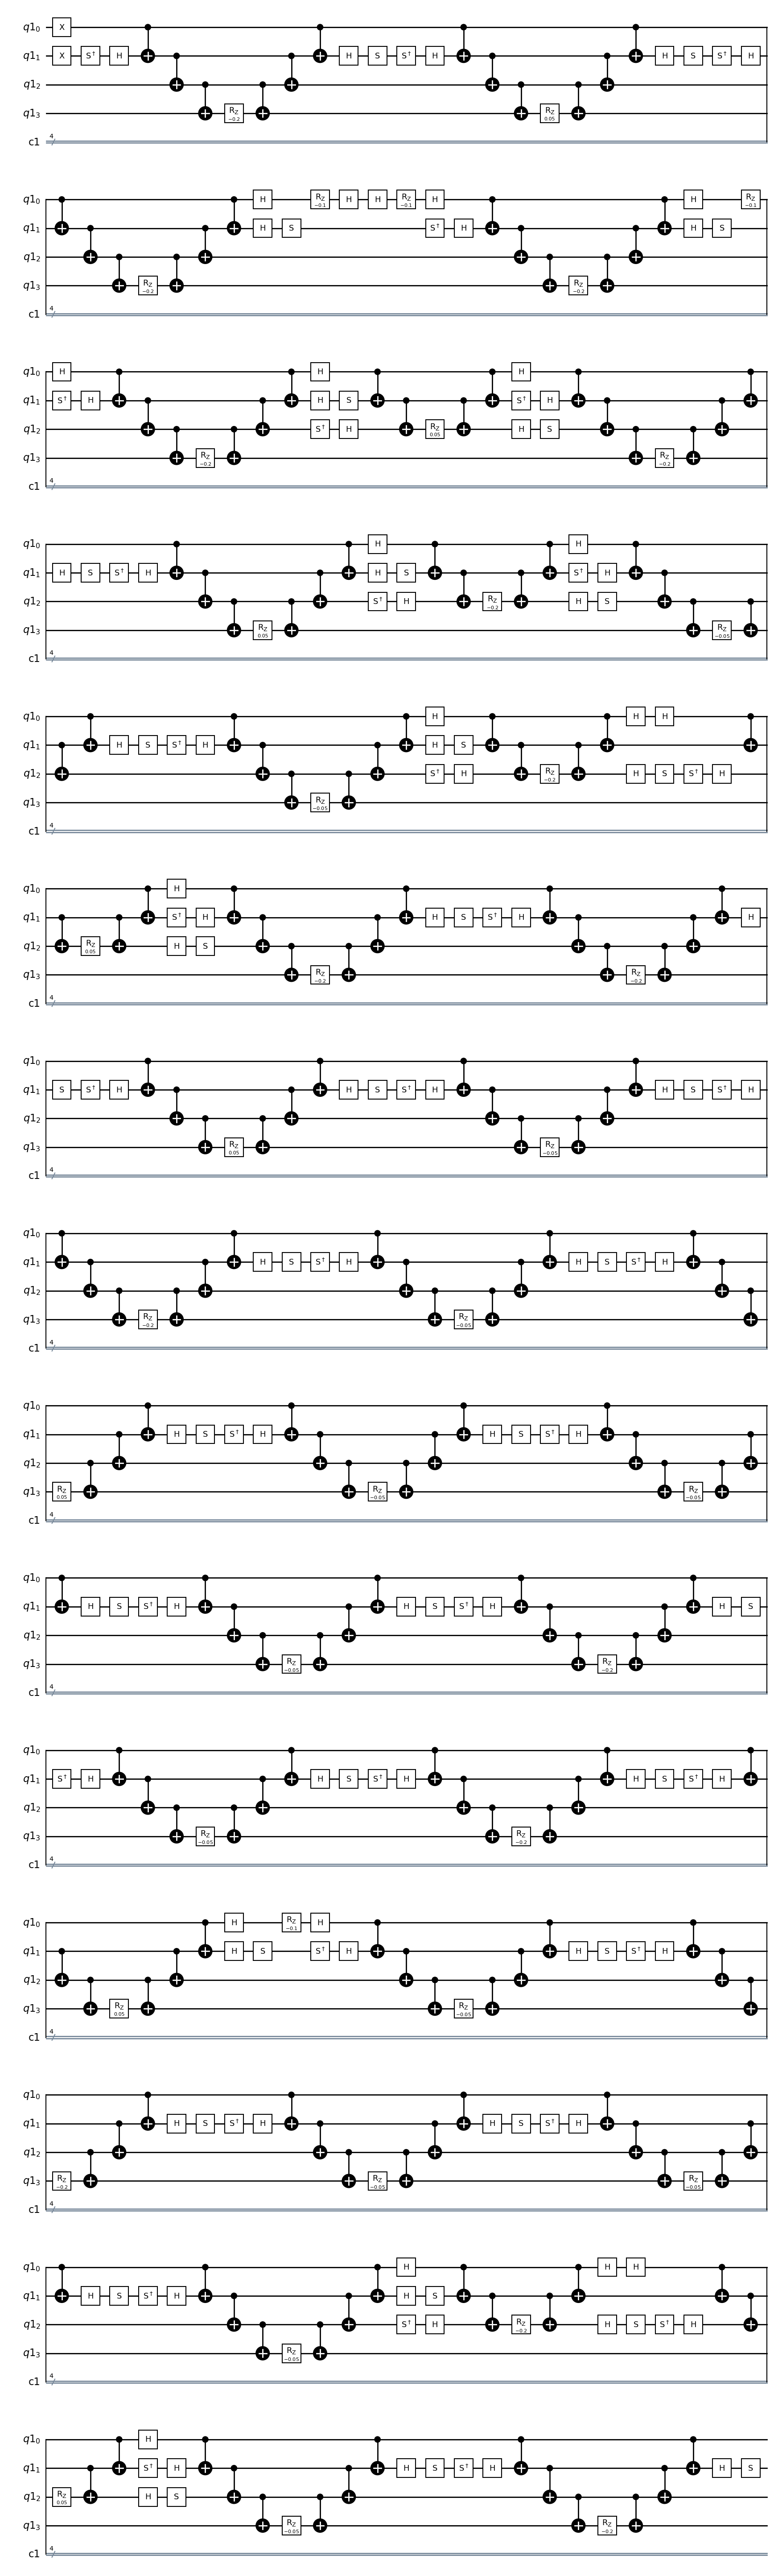

In [9]:
indices, logits = model.generate(torch.tensor([[0]]), 40)
cost.sequence.tool = "qiskit"
print(indices)
cost.sequence._get_circuit(indices.numpy()[0]).draw()